# Variational AutoEncoder (VAE)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import matplotlib.pyplot as plt

## VAE model

In [4]:
IMG_SHAPE = (64, 64, 3)
LATENT_DIM = 128
KERNEL_SIZE = 4

# Encode the image into the latent space of dimension LATENT_DIM
def build_encoder():
    inputs = Input(shape=IMG_SHAPE)
    x = layers.Conv2D(32, KERNEL_SIZE, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, KERNEL_SIZE, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, KERNEL_SIZE, strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    z_mean = layers.Dense(LATENT_DIM)(x)
    z_log_var = layers.Dense(LATENT_DIM)(x)
    return Model(inputs, [z_mean, z_log_var], name='encoder')

In [6]:
# Sample from latent space the vector z = mean + sqrt(exp(log_var)) * epsilon
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
# Decode from the latent space the original image
def build_decoder():
  latent_inputs = Input(shape=(LATENT_DIM,))
  x = layers.Dense(8 * 8 * LATENT_DIM, activation='relu')(latent_inputs)
  x = layers.Reshape((8, 8, LATENT_DIM))(x)
  x = layers.Conv2DTranspose(64, KERNEL_SIZE, strides=2, padding='same', activation='relu')(x)
  x = layers.Conv2DTranspose(32, KERNEL_SIZE, strides=2, padding='same', activation='relu')(x)
  outputs = layers.Conv2DTranspose(3, KERNEL_SIZE, strides=2, padding='same', activation='sigmoid')(x)
  return Model(latent_inputs, outputs, name='decoder')

In [37]:
# VAE class that has an encoder, a sampler, a decoder and the VAE loss
class VAE(Model):

  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.sampler = Sampling()
    self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

  def compile(self, optimizer):
    super().compile()
    self.optimizer = optimizer
    self.recon_loss_fn = tf.keras.losses.MeanSquaredError()

  def train_step(self, data):

    if isinstance(data, tuple):
      data = data[0]

    with tf.GradientTape() as tape:
      z_mean, z_log_var = self.encoder(data)
      z = self.sampler([z_mean, z_log_var])
      decoded_image = self.decoder(z)
      loss = self.vae_loss(data, decoded_image, (z_mean, z_log_var))

    grads = tape.gradient(loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(loss)
    return {
      "loss": self.total_loss_tracker.result()
    }

  def vae_loss(self, data, decoded_image, encoder_output):
    z_mean, z_log_var = encoder_output
    recon_loss = tf.reduce_mean(tf.reduce_sum(self.recon_loss_fn(data, decoded_image)))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
    return recon_loss + kl_loss

## Data preparation

In [40]:
import kagglehub, os
from PIL import Image

# Download latest version
path = kagglehub.dataset_download("ashishjangra27/doodle-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.72G/4.72G [03:46<00:00, 22.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashishjangra27/doodle-dataset/versions/1


In [41]:
path += "/doodle"
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ashishjangra27/doodle-dataset/versions/1/doodle


In [43]:
import shutil

new_path = "/content/doodle"

shutil.copytree(path, new_path)

KeyboardInterrupt: 

In [ ]:
!rm /content/PetImages

In [31]:
# Check images
for root, dirs, files in os.walk(new_path):
    for file in files:
        filepath = os.path.join(root, file)
        try:
            with Image.open(filepath) as img:
                img.verify()
        except Exception as not_valid_img:
            print(f"Bad image: {filepath} ({not_valid_img})")
            try:
              os.remove(filepath)
            except Exception as delete_error:
              print(f"Failed to delete {filepath}: {delete_error}")

Bad image: /content/PetImages/Dog/11702.jpg (cannot identify image file '/content/PetImages/Dog/11702.jpg')
Bad image: /content/PetImages/Dog/Thumbs.db (cannot identify image file '/content/PetImages/Dog/Thumbs.db')


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Bad image: /content/PetImages/Cat/Thumbs.db (cannot identify image file '/content/PetImages/Cat/Thumbs.db')
Bad image: /content/PetImages/Cat/666.jpg (cannot identify image file '/content/PetImages/Cat/666.jpg')


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(
    new_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='input'  # same as input for autoencoders
)


Found 24998 images belonging to 2 classes.


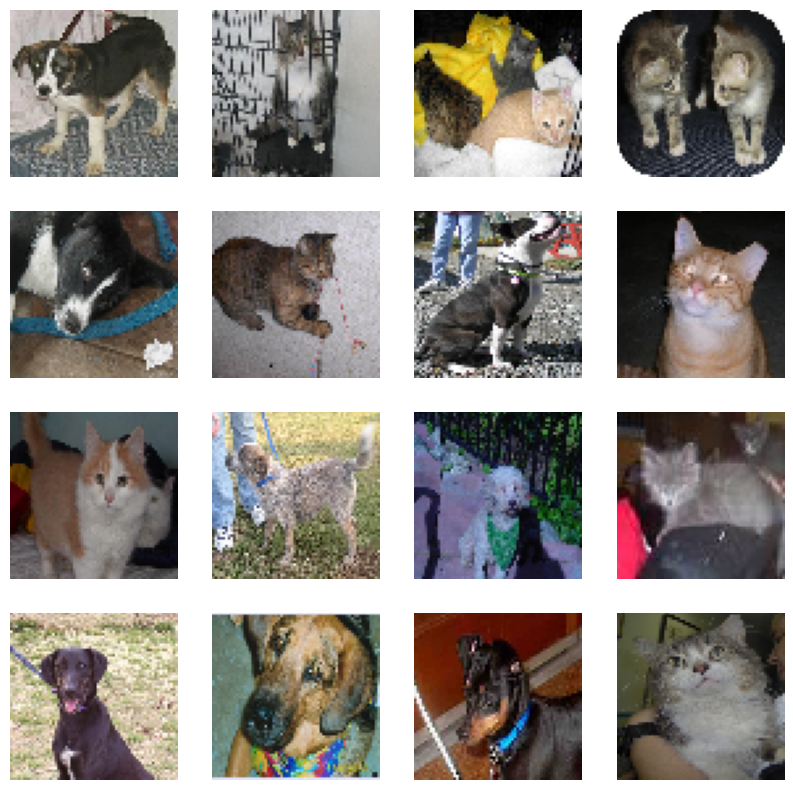

In [35]:
images, labels = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()

## Training

In [36]:
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

vae.fit(train_gen, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inputs shape: (None, 64, 64, 3)
Outputs shape: (None, 64, 64, 3)
Loss shape: ()
Inputs shape: (None, 64, 64, 3)
Outputs shape: (None, 64, 64, 3)
Loss shape: ()
280/782 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - loss: 0.0759

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - loss: 0.0709
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - loss: 0.0670
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.0670
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - loss: 0.0671
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - loss: 0.0673
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 0.0669
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - loss: 0.0672
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - loss: 0.0673
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - loss: 0.0669
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - loss: 0.0672


## Testing

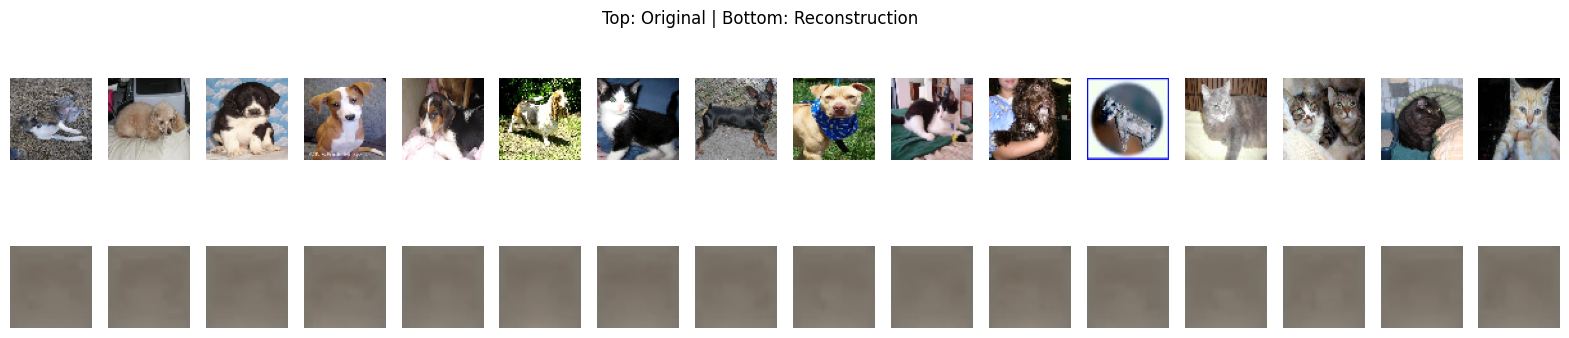

In [38]:
# Show real images reconstruction

real_images, _ = next(train_gen)
real_images = real_images[:16]

z_mean, z_log_var = vae.encoder(real_images)
z = vae.sampler([z_mean, z_log_var])
recon_images = vae.decoder(z)

# Plot
n = len(real_images)
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(real_images[i])
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_images[i])
    plt.axis("off")

plt.suptitle("Top: Original | Bottom: Reconstruction")
plt.show()

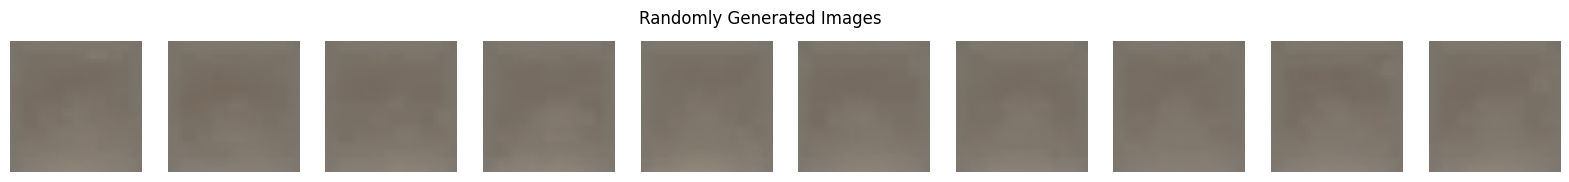

In [39]:
def sample_and_plot(decoder, n=10):
    z_random = tf.random.normal(shape=(n, LATENT_DIM))
    generated = decoder(z_random)

    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated[i])
        plt.axis("off")
    plt.suptitle("Randomly Generated Images")
    plt.show()

sample_and_plot(vae.decoder)